# Dealing with BARRA data with GDAL and rasterio

In [81]:
filename = '/g/data/ma05/BARRA_R/v1/forecast/spec/accum_prcp/1990/01/accum_prcp-fc-spec-PT1H-BARRA_R-v1-19900101T0000Z.sub.nc'

In [82]:
!ncdump -hs $filename

netcdf accum_prcp-fc-spec-PT1H-BARRA_R-v1-19900101T0000Z.sub {
dimensions:
	time = 6 ;
	bnds = 2 ;
	longitude = 1200 ;
	latitude = 768 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "hours since 1970-01-01 00:00:00" ;
		time:standard_name = "time" ;
		time:calendar = "gregorian" ;
		time:long_name = "time" ;
		time:MD5 = "ba6811b22f775971b3cc9655ffdd062f" ;
		time:_Storage = "contiguous" ;
		time:_Endianness = "little" ;
	float bnds(bnds) ;
		bnds:MD5 = "b5ce7b2e71f14b237f1d8a6c2dacd247" ;
		bnds:_Storage = "contiguous" ;
		bnds:_Endianness = "little" ;
	float longitude(longitude) ;
		longitude:axis = "X" ;
		longitude:units = "degrees_east" ;
		longitude:standard_name = "longitude" ;
		longitude:long_name = "longitude" ;
		longitude:MD5 = "d8bf06faf2a0abdfef6ca96e96d80170" ;
		longitude:_Storage = "contiguous" ;
		longitude:_Endianness = "little" ;
	float latitude(latitude) ;
		latitude:axis = "Y" ;
		latitude:units = "degrees_north" ;
		latitude:standa

		:_IsNetcdf4 = 1 ;
		:_Format = "netCDF-4" ;
}


In [83]:
!gdalinfo $filename

Driver: netCDF/Network Common Data Format
Files: /g/data/ma05/BARRA_R/v1/forecast/spec/accum_prcp/1990/01/accum_prcp-fc-spec-PT1H-BARRA_R-v1-19900101T0000Z.sub.nc
Size is 1200, 768
Coordinate System is:
GEOGCS["unknown",
    DATUM["unknown",
        SPHEROID["Sphere",6371229,0]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]]]
Origin = (65.000000302248736,19.480003053548284)
Pixel Size = (0.110000005854081,-0.110000003580941)
Metadata:
  accum_prcp#cell_methods=time: sum
  accum_prcp#coordinates=forecast_period forecast_reference_time time
  accum_prcp#description=Total precipitation amount at the surface. This is the sum of the large scale rainfall, convective rainfall and snowfall at the surface.
  accum_prcp#grid_mapping=latitude_longitude
  accum_prcp#long_name=TOTAL PRECIPITATION AMOUNT  KG/M2/TS
  accum_prcp#MD5=d007fd135537e47abd308b6247653658
  accum_prcp#standard_name=precipitation_amount
  accum_prcp#stash_code=5226
  accum_

In [3]:
!rio info $filename | jq .

{
  "bounds": [
    65.00000030224874,
    -64.9999996966147,
    197.0000073271458,
    19.480003053548284
  ],
  "colorinterp": [
    "undefined",
    "undefined",
    "undefined",
    "undefined",
    "undefined",
    "undefined"
  ],
  "count": 6,
  "crs": "GEOGCS[\"unknown\",DATUM[\"unknown\",SPHEROID[\"Sphere\",6371229,0]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]]]",
  "descriptions": [
    null,
    null,
    null,
    null,
    null,
    null
  ],
  "driver": "netCDF",
  "dtype": "float64",
  "height": 768,
  "indexes": [
    1,
    2,
    3,
    4,
    5,
    6
  ],
  "lnglat": [
    131.00000381469727,
    -22.759998321533203
  ],
  "mask_flags": [
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ],
    [
      "nodata"
    ]
  ],
  "nodata": -1073741824,
  "res": [
    0.11000000585408087,
    0.11000000358094138
  ],
  "shape": [
    768,
  

In [35]:
import rasterio
import os
from matplotlib import pyplot as plt
from scipy.stats import describe
import xarray as xr
import json
import numpy as np

In [75]:
ds = rasterio.open(filename)

### A plain read - data appears upside down

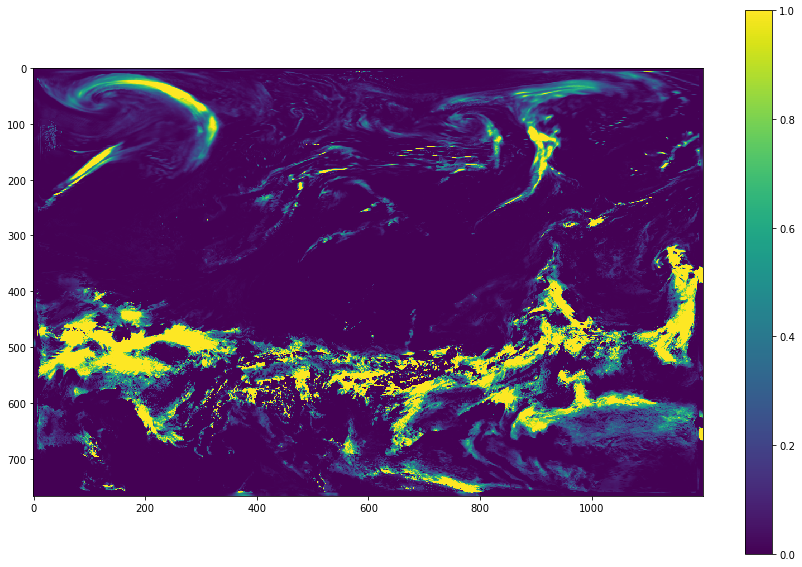

In [84]:
plt.figure(figsize = (15,10))
plt.imshow(ds.read(1), clim=(0.0, 1.0))
plt.colorbar()

### Compare available profiles with different bottoms up settings
The only difference is the read speed

In [73]:
tests = [
    (True, '/g/data/ma05/BARRA_R/v1/forecast/spec/accum_prcp/1990/01/accum_prcp-fc-spec-PT1H-BARRA_R-v1-19900101T1200Z.sub.nc'),
    (False, '/g/data/ma05/BARRA_R/v1/forecast/spec/accum_prcp/1990/01/accum_prcp-fc-spec-PT1H-BARRA_R-v1-19900101T1800Z.sub.nc'),
]

for bottomup, filename in tests:
    with rasterio.Env(GDAL_NETCDF_BOTTOMUP=bottomup) as env:
        for key, val in env.options.items():
            print(key, val)
        with rasterio.open(filename) as ds:
            print(ds.transform)
            print(ds.bounds)
            profile = dict(ds.profile)
            del profile['crs']
            print(json.dumps(profile, indent=2))
            %time ds.read(1)
    print()
            
    


GDAL_NETCDF_BOTTOMUP True
| 0.11, 0.00, 65.00|
| 0.00,-0.11, 19.48|
| 0.00, 0.00, 1.00|
BoundingBox(left=65.00000030224874, bottom=-64.9999996966147, right=197.0000073271458, top=19.480003053548284)
{
  "driver": "netCDF",
  "dtype": "float64",
  "nodata": -1073741824.0,
  "width": 1200,
  "height": 768,
  "count": 6,
  "transform": [
    0.11000000585408087,
    0.0,
    65.00000030224874,
    0.0,
    -0.11000000358094138,
    19.480003053548284,
    0.0,
    0.0,
    1.0
  ],
  "tiled": false
}
CPU times: user 18.5 s, sys: 752 ms, total: 19.3 s
Wall time: 19.4 s

GDAL_NETCDF_BOTTOMUP False
| 0.11, 0.00, 65.00|
| 0.00,-0.11, 19.48|
| 0.00, 0.00, 1.00|
BoundingBox(left=65.00000030224874, bottom=-64.9999996966147, right=197.0000073271458, top=19.480003053548284)
{
  "driver": "netCDF",
  "dtype": "float64",
  "nodata": -1073741824.0,
  "width": 1200,
  "height": 768,
  "count": 6,
  "transform": [
    0.11000000585408087,
    0.0,
    65.00000030224874,
    0.0,
    -0.1100000035809413

### Check that we get the same data when reading with either bottomup setting

In [46]:

with rasterio.Env(GDAL_NETCDF_BOTTOMUP=True):
    with rasterio.open(filename) as ds:
        bottomup_data = ds.read(1)
with rasterio.Env(GDAL_NETCDF_BOTTOMUP=False):
    with rasterio.open(filename) as ds:
        data = ds.read(1)

np.all(bottomup_data == data)

True

In [51]:
ds = rasterio.open(filename)

In [39]:
ds.block_shapes

[(256, 400), (256, 400), (256, 400), (256, 400), (256, 400), (256, 400)]

### Compare windowed Reads

Again, we get identical data.

In [78]:
from rasterio.windows import Window

with rasterio.Env(GDAL_NETCDF_BOTTOMUP=True) as env:
    with rasterio.open(filename) as src:
        w1 = src.read(1, window=Window(0, 0, 512, 256))
with rasterio.Env(GDAL_NETCDF_BOTTOMUP=False) as env:
    with rasterio.open(filename) as src:
        w2 = src.read(1, window=Window(0, 0, 512, 256))

In [80]:
np.all(w1 == w2)

True